In [1]:
import pandas as pd
import os
import re

# Detectamos los archivos .txt válidos (los que tienen datos de absorbancia)
archivos_txt = [f for f in os.listdir() if f.endswith('.txt') and f != 'AOxMM.csv']

# Función para extraer gramaje del nombre del archivo
def extraer_gramos(nombre):
    match = re.search(r'(\d+_?\d*)g', nombre)
    if match:
        return float(match.group(1).replace('_', '.'))
    return float('inf')

# Ordenamos los archivos por gramaje (más limpio para visualizar después)
archivos_ordenados = sorted(archivos_txt, key=extraer_gramos)

# Leemos y procesamos los archivos
dataframes = []
for archivo in archivos_ordenados:
    df = pd.read_csv(archivo, sep=None, engine='python')  # autodetecta separador
    df = df[pd.to_numeric(df.iloc[:, 0], errors='coerce').notna()]
    
    nombre_columna = os.path.splitext(archivo)[0]
    df.columns = ['nm', nombre_columna]
    df[nombre_columna] = pd.to_numeric(df[nombre_columna], errors='coerce')
    dataframes.append(df)

# Unimos los datos por la columna de longitud de onda
df_consolidado = dataframes[0]
for df in dataframes[1:]:
    df_consolidado = pd.merge(df_consolidado, df, on='nm', how='outer')

# Guardamos el archivo final
df_consolidado.to_csv('TOxMM_matrix.csv', index=False)

print("Archivo 'TOxMM_matrix.csv' creado con éxito")

Archivo 'TOxMM_matrix.csv' creado con éxito


In [2]:
import pandas as pd
datos=pd.read_csv("TOxMM_matrix.csv")

In [3]:
datos.head()

,nm,TOxMM20,TOxMM05,TOxMM50,TOxMM
0,390.0,NaN,NaN,NaN,NaN
1,391.0,NaN,NaN,NaN,NaN
2,392.0,NaN,NaN,NaN,NaN
3,393.0,NaN,NaN,NaN,NaN
4,394.0,31.186,48.866,28.14,39.213


In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nm       361 non-null    float64
 1   TOxMM20  353 non-null    float64
 2   TOxMM05  353 non-null    float64
 3   TOxMM50  353 non-null    float64
 4   TOxMM    353 non-null    float64
dtypes: float64(5)
memory usage: 14.2 KB


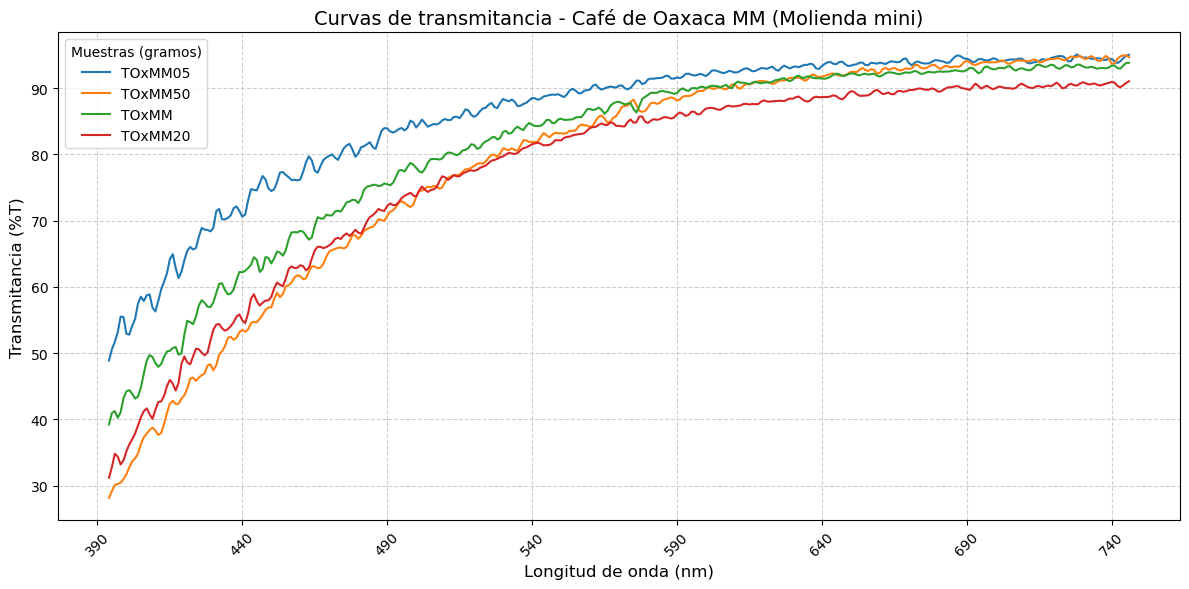

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargamos el archivo con las mediciones de transmitancia almacenados en una matriz de datos
df = pd.read_csv("TOxMM_matrix.csv")

# Limpiamos datos fuera del rango de %T [0, 100]
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[(df[columna] < 0) | (df[columna] > 100), columna] = None

# Copiamos el DataFrame limpio
df_clean = df.copy()

# Obtenemos los valores máximos de cada curva
maximos = {
    columna: df_clean[columna].max(skipna=True)
    for columna in df_clean.columns[1:]
}

# Ordenamos de mayor a menor para que la leyenda coincida con las curvas
columnas_ordenadas = sorted(maximos, key=maximos.get, reverse=True)

# Creamos figura
plt.figure(figsize=(12, 6))

# Dibujamos las curvas solo con valores válidos (sin NaNs)
for columna in columnas_ordenadas:
    datos_validos = df_clean[['nm', columna]].dropna()
    plt.plot(datos_validos['nm'], datos_validos[columna], label=columna)

# Etiquetas y estilo (estética de los ejes)
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Transmitancia (%T)', fontsize=12)
plt.title('Curvas de transmitancia - Café de Oaxaca MM (Molienda mini)', fontsize=14)
plt.legend(title='Muestras (gramos)', fontsize=10)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Cargar archivo de transmitancia ===
ruta = "TOxMM_matrix.csv"
df = pd.read_csv(ruta)

# === Columnas
col_nm = [c for c in df.columns if 'nm' in c.lower()][0]
col_transmitancia = [c for c in df.columns if c != col_nm]

# === Regiones espectrales
regiones = {
    '100–200 nm': (100, 200),
    '200–300 nm': (200, 300),
    '300–400 nm': (300, 400),
    '400–500 nm': (400, 500),
    '500–600 nm': (500, 600),
    '600–700 nm': (600, 700),
    '700–800 nm': (700, 800)
}

# === Colores
colormap_base = plt.get_cmap('tab10')
colormap = colormap_base(np.linspace(0, 1, len(col_transmitancia)))
colores_hex = [mcolors.to_hex(c) for c in colormap]

# === Figura
fig = go.Figure()
fig.update_layout(
    title="Curvas de transmitancia - Café de Oaxaca MM (Molienda mini)",
    xaxis_title="Longitud de onda (nm)",
    yaxis_title="Transmitancia (%)",
    legend_title="Curva",
    template="plotly_white",
    margin=dict(l=40, r=40, t=80, b=40),
)

# === Métricas
metricas = []
for i, col in enumerate(col_transmitancia):
    datos = df[[col_nm, col]].dropna().rename(columns={col_nm: 'nm', col: 'transmitancia'})
    datos['transmitancia'] = pd.to_numeric(datos['transmitancia'], errors='coerce')
    datos = datos.dropna()
    if datos.empty:
        continue

    fig.add_trace(go.Scatter(
        x=datos['nm'],
        y=datos['transmitancia'],
        mode='lines',
        name=col,
        line=dict(color=colores_hex[i])
    ))

    max_val = datos['transmitancia'].max()
    min_val = datos['transmitancia'].min()
    avg = datos['transmitancia'].mean()
    std = datos['transmitancia'].std()
    auc = np.trapezoid(datos['transmitancia'], datos['nm'])
    lambda_max = datos['nm'][datos['transmitancia'].idxmax()]
    lambda_min = datos['nm'][datos['transmitancia'].idxmin()]

    proms_reg = {}
    for region, (a, b) in regiones.items():
        reg_vals = datos.loc[(datos['nm'] >= a) & (datos['nm'] <= b), 'transmitancia']
        proms_reg[region] = f"{reg_vals.mean():.2f}" if not reg_vals.empty else "—"

    metricas.append({
        'Color de curva': colores_hex[i],
        'Curva': col,
        'Máx (%T)': round(max_val, 2),
        'Mín (%T)': round(min_val, 2),
        'Promedio (%)': round(avg, 2),
        'Desv. Std': round(std, 2),
        'AUC': round(auc, 2),
        'λ máx (nm)': round(lambda_max, 2),
        'λ mín (nm)': round(lambda_min, 2),
        **proms_reg
    })

# === Tabla HTML
df_metricas = pd.DataFrame(metricas)
tabla_html = "<table class='styled-table'><thead><tr>"
for col in df_metricas.columns:
    tabla_html += f"<th>{col}</th>"
tabla_html += "</tr></thead><tbody>"
for _, row in df_metricas.iterrows():
    tabla_html += "<tr>"
    for col in df_metricas.columns:
        if col == "Color de curva":
            tabla_html += f"<td style='background-color:{row[col]};'></td>"
        else:
            tabla_html += f"<td>{row[col]}</td>"
    tabla_html += "</tr>"
tabla_html += "</tbody></table>"

# === HTML Final
fecha = datetime.now().strftime('%d-%m-%Y %H:%M:%S')
grafica_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

html_final = f"""
<!DOCTYPE html>
<html lang="es">
<head>
  <meta charset="UTF-8">
  <title>Reporte de Transmitancia UV-Vis</title>
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <style>
    body {{
      font-family: 'Segoe UI', Tahoma, sans-serif;
      margin: 40px;
      background-color: #fdfdfd;
      color: #222;
    }}
    h1 {{
      color: #111;
    }}
    h2 {{
      margin-top: 40px;
    }}
    .info {{
      margin-bottom: 20px;
    }}
    .lab {{
      margin-top: 40px;
      font-size: 0.95em;
      background-color: #f0f8ff;
      padding: 15px;
      border-left: 6px solid #009879;
    }}
    .styled-table {{
      border-collapse: collapse;
      margin-top: 20px;
      font-size: 1em;
      width: 100%;
      box-shadow: 0 0 10px rgba(0, 0, 0, 0.05);
    }}
    .styled-table thead tr {{
      background-color: #009879;
      color: #ffffff;
      text-align: left;
    }}
    .styled-table th, .styled-table td {{
      padding: 12px 15px;
      border: 1px solid #ddd;
      text-align: center;
    }}
    .styled-table tbody tr:nth-child(even) {{
      background-color: #f3f3f3;
    }}
    .plotly-graph-div {{
      width: 100% !important;
      height: auto !important;
    }}
  </style>
</head>
<body>

  <h1>Curvas de transmitancia - Café de Oaxaca MM (Molienda Mini)</h1> 

  <div class="info">
    <p><strong>Fecha:</strong> {fecha}</p>
  </div>

  {grafica_html}

  <h2>Métricas espectrales por curva</h2>
  {tabla_html}

  <div>
    <p>Las curvas de transmitancia permiten identificar la transparencia relativa de la muestra a lo largo del espectro. Una menor transmitancia puede sugerir absorción fuerte en ciertas regiones, lo cual es útil para análisis de compuestos activos presentes en el café.</p>
  </div>

  <div class="lab">
    <strong>Nombre del proyecto: CafeLab</strong><br><br>
    <strong>Colaboradores:</strong><br>
    Martín Rodolfo Palomino Merino – Profesor investigador, jefe responsable del laboratorio de caracterización de materiales (FCFM-BUAP).<br>
    Lizeth Jazmín Orozco García – Colaborador principal.<br>
    Julio Alfredo Ballinas García – Colaborador del proyecto.
  </div>

</body>
</html>
"""

# === Guardar archivo
with open("Comparativa_muestras_transmitancia.html", "w", encoding="utf-8") as f:
    f.write(html_final)

print("✅ HTML generado: Comparativa_muestras_transmitancia.html")
print("Rango de longitudes de onda:", df['nm'].min(), "a", df['nm'].max())
fig.show()

✅ HTML generado: Comparativa_muestras_transmitancia.html
Rango de longitudes de onda: 390.0 a 750.0
